In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

from google.colab import files
files.upload()

# **Load Data**

In [2]:
df_features = pd.read_csv('/content/raw_df.csv')
df_features

,job_title,seniority_level,status,company,location,post_date,headquarter,industry,ownership,company_size,revenue,salary,skills
0,data scientist,senior,hybrid,company_003,"Grapevine, TX . Hybrid",17 days ago,"Bentonville, AR, US",Retail,Public,€352.44B,Public,"€100,472 - €200,938","['spark', 'r', 'python', 'scala', 'machine lea..."
1,data scientist,lead,hybrid,company_005,"Fort Worth, TX . Hybrid",15 days ago,"Detroit, MI, US",Manufacturing,Public,"155,030",€51.10B,"€118,733","['spark', 'r', 'python', 'sql', 'machine learn..."
2,data scientist,senior,on-site,company_007,"Austin, TX . Toronto, Ontario, Canada . Kirkla...",a month ago,"Redwood City, CA, US",Technology,Public,"25,930",€33.80B,"€94,987 - €159,559","['aws', 'git', 'python', 'docker', 'sql', 'mac..."
3,data scientist,senior,hybrid,company_008,"Chicago, IL . Scottsdale, AZ . Austin, TX . Hy...",8 days ago,"San Jose, CA, US",Technology,Public,"34,690",€81.71B,"€112,797 - €194,402","['sql', 'r', 'python']"
4,data scientist,NaN,on-site,company_009,On-site,3 days ago,"Stamford, CT, US",Finance,Private,"1,800",Private,"€114,172 - €228,337",[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,data scientist,senior,NaN,company_171,"Bengaluru, Karnataka, India",a day ago,"Armonk, NY, US",Technology,Public,"524,598",€120.29B,"€33,288 - €53,080","['pytorch', 'python', 'sql', 'machine learning..."
940,machine learning engineer,senior,NaN,company_134,"Melbourne, Victoria, Australia",a month ago,"Seattle, WA, US",Retail,Public,"865,456",€838.78B,"€64,290","['amazon', 'machine learning']"
941,data scientist,midlevel,on-site,company_395,"McLean, VA",11 days ago,"McLean, VA, US",Retail,Public,"55,150",€36.29B,"€145,904 - €166,510","['spark', 'aws', 'r', 'python', 'scala', 'sql'..."
942,data scientist,midlevel,on-site,company_395,"New York, NY",17 days ago,"McLean, VA, US",Retail,Public,"55,110",€36.34B,"€159,149 - €181,595","['spark', 'aws', 'r', 'python', 'scala', 'sql'..."


In [ ]:
df_features.isnull().sum()

,0
job_title,3
seniority_level,60
status,256
company,0
location,2
post_date,0
headquarter,0
industry,0
ownership,47
company_size,0


<Axes: >

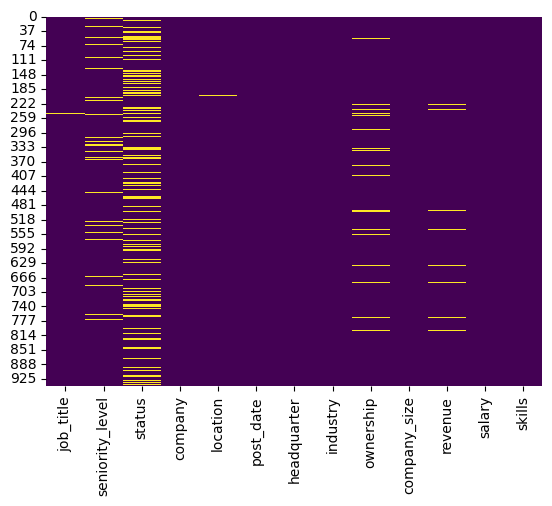

In [ ]:
sns.heatmap(df_features.isnull(), cbar=False, cmap='viridis')

# **Utils**

In [ ]:
def words_to_num(text: str) -> str:
    """Converts number words to digits"""
    transformer_dict = {
        "zero": "0", "a ": "1 ", "one": "1", "two": "2", "three": "3", "four": "4",
        "five": "5", "six": "6", "seven": "7", "eight": "8", "nine": "9",
        "ten": "10", "eleven": "11", "twelve": "12",
    }
    for word, num in transformer_dict.items():
        text = text.replace(word, num)
    return text

# **Feature Extracting**

## **Post Date**

In [ ]:
# Post Date: Calculate in terms of days

def extract_post_date(el) -> int:
  """Extracts job post date in terms of past days"""
  el = words_to_num(el)
  number = el.split()[0]
  if 'hour' in el.lower():
    days = 0
  elif 'day' in el.lower():
    days = int(number)
  elif 'month' in el.lower():
    days = int(number) * 30
  elif 'year' in el.lower():
    days = int(number) * 365
  else:
    raise ValueError(f'No one of expected keywords provided in the input: {el}')
  return days

df_features['post_date'] = df_features['post_date'].apply(extract_post_date)

In [ ]:
len(df_features[df_features['post_date']>360])

6

In [ ]:
# drop jobs posted more than 1 year ago

mask = df_features['post_date']>360
df_features = df_features[~ mask]

## **Ownership, Company size & Revenue**

In [ ]:
# Mixed columns issue: for jobs in which the company description has not the
# entire information , these columns are mixed

for i in range(10):
  print('--------------------------------')
  print('ownership = ', df_features.iloc[i]['ownership'])
  print('company_size = ', df_features.iloc[i]['company_size'])
  print('revenue = ', df_features.iloc[i]['revenue'])


--------------------------------
ownership =  Public
company_size =  €352.44B
revenue =  Public
--------------------------------
ownership =  Public
company_size =  155,030
revenue =  €51.10B
--------------------------------
ownership =  Public
company_size =  25,930
revenue =  €33.80B
--------------------------------
ownership =  Public
company_size =  34,690
revenue =  €81.71B
--------------------------------
ownership =  Private
company_size =  1,800
revenue =  Private
--------------------------------
ownership =  Private
company_size =  150
revenue =  €2.16B
--------------------------------
ownership =  nan
company_size =  17,471
revenue =  Education
--------------------------------
ownership =  Public
company_size =  900
revenue =  Public
--------------------------------
ownership =  Private
company_size =  126
revenue =  Private
--------------------------------
ownership =  Public
company_size =  5,520
revenue =  €61.06B


In [ ]:
# Ownership; print columns containing Public or Private (unique values from the ownership column)

ownerships = df_features['ownership'].dropna().unique()

for col in df_features.columns:
   if df_features[col].isin(ownerships).sum() != 0:
    print(col)

ownership
company_size
revenue


In [ ]:
df_features['ownership'].value_counts(), '\n', df_features['ownership'].isnull().sum()

(ownership
 Public     579
 Private    313
 Name: count, dtype: int64,
 '\n',
 np.int64(46))

In [ ]:
# Replace ownership from revenue

mask = df_features['revenue'].isin(ownerships)
df_features.loc[mask, 'ownership'] = df_features.loc[mask, 'revenue']
df_features['ownership'].value_counts(), '\n', df_features['ownership'].isnull().sum()

(ownership
 Public     579
 Private    313
 Name: count, dtype: int64,
 '\n',
 np.int64(46))

In [ ]:
# Replace ownership from company_size

mask = df_features['company_size'].isin(ownerships)
df_features.loc[mask, 'ownership'] = df_features.loc[mask, 'company_size']
df_features['ownership'].value_counts(), '\n', df_features['ownership'].isnull().sum()

(ownership
 Public     579
 Private    327
 Name: count, dtype: int64,
 '\n',
 np.int64(32))

In [ ]:
# Revenue; columns which contain € sign

for col in df_features.columns:
   if df_features[col].astype(str).str.contains('€').any():
    print(col)


company_size
revenue
salary


In [ ]:
df_features['revenue'].isnull().sum()

np.int64(14)

In [ ]:
# Replace revenue from company_size

mask = df_features['company_size'].str.contains('€')
df_features.loc[mask, 'revenue'] = df_features.loc[mask, 'company_size']
df_features['revenue'].isnull().sum()

np.int64(14)

In [ ]:
# Company Size; check if any of company size is in the revenue column

mask = ~df_features['revenue'].str.contains('€', na=False) & ~df_features['revenue'].isin(ownerships)
df_features.loc[mask, 'revenue']

,revenue
6,Education
11,Education
28,Education
34,Nonprofit
56,Education
65,Education
116,Education
223,Nonprofit
224,NaN
237,NaN


In [ ]:
# Replace wrong company sizes with None

mask = df_features['company_size'].str.contains('€') | df_features['company_size'].isin(ownerships)
df_features.loc[mask, 'company_size'] = None

In [ ]:
# Wrong revenue which has to be cleaned later

mask = df_features['revenue'].astype(str).str.contains('€', na=False)
df_features.loc[~mask, 'revenue']

,revenue
4,Private
6,Education
7,Public
8,Private
11,Education
...,...
827,Public
832,Public
840,Public
891,Public


In [ ]:
# Replace null revenue

mask = df_features['revenue'].astype(str).str.contains('€', na=False)
df_features.loc[~mask, 'revenue'] = None
df_features['revenue'].isnull().sum()

np.int64(493)

In [ ]:
def convert_revenue_to_numeric(revenue_str):
    """Converts strs like €352.44B to numbers & express as scientific notation"""
    if isinstance(revenue_str, str):
        revenue_str = revenue_str.replace('€', '').replace('B', 'e9').replace('M', 'e6').replace(',', '')
        try:
            return float(revenue_str)
        except ValueError:
            return None
    return None

df_features['revenue'] = df_features['revenue'].apply(convert_revenue_to_numeric)

display(df_features['revenue'].head())

/tmp/ipython-input-666147159.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['revenue'] = df_features['revenue'].apply(convert_revenue_to_numeric)


,revenue
0,3.524400e+11
1,5.110000e+10
2,3.380000e+10
3,8.171000e+10
4,NaN


In [ ]:
# Convert company size to number

df_features['company_size'] = df_features['company_size'].apply(lambda x: int(''.join(x.split(','))) if type(x) == str else None)

## **Location & Headquarter**

In [ ]:
mask = pd.isnull(df_features['status']) & pd.notnull(df_features['location'])
len(df_features[mask])

253

In [ ]:
# Check if there are any rows with none status that the location column has the status information

statuses = df_features['status'].dropna().unique()
mask = pd.isnull(df_features['status']) & df_features['location'].str.lower().str.split('.').isin(statuses)
df_features[mask]

,job_title,seniority_level,status,company,location,post_date,headquarter,industry,ownership,company_size,revenue,salary,skills


In [ ]:
df_features['test'] = None
statuses = df_features['status'].dropna().unique()

def extract_single_status(location, statuses):
    """Extracts status information from the location column"""
    if pd.isna(location):
        return None
    location_parts = [l.strip() for l in location.lower().split('.')]
    for part in location_parts:
        if part in statuses:
            return part
    return None

df_features['test'] = df_features.apply(lambda x: extract_single_status(x['location'], statuses), axis=1)
df_features['test']

/tmp/ipython-input-1536495917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['test'] = None
/tmp/ipython-input-1536495917.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['test'] = df_features.apply(lambda x: extract_single_status(x['location'], statuses), axis=1)


,test
0,hybrid
1,hybrid
2,None
3,hybrid
4,on-site
...,...
939,None
940,None
941,None
942,None


In [ ]:
df_features['test'].isnull().sum()

np.int64(631)

In [ ]:
mask = pd.isnull(df_features['status']) &  pd.notnull(df_features['test'])
len(df_features.loc[mask]), mask.sum()

(0, np.int64(0))

**So there is no row with null status in which the location column contains the status information**

In [ ]:
# Location

pd.set_option('display.max_rows', 431)
display(df_features['location'].value_counts())

,count
location,
"Bengaluru, Karnataka, India",52
Fully Remote,35
"New York, NY",22
United States,22
On-site,18
"San Francisco, CA",17
"Mountain View, CA",17
"Sunnyvale, CA",13
"Bengaluru, Karnataka, India . Hybrid",12


In [ ]:
def extract_location(el):
  if not pd.isna(el):
    parts = el.strip().split('.')
    if len(parts)>2:
      location = 'multi-location'
    else:
      location = parts[0].split(',')[-1].strip()
  else:
    location = None
  return location
df_features['test'] = None
df_features['test'] = df_features['location'].apply(extract_location)

/tmp/ipython-input-3891869389.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['test'] = None
/tmp/ipython-input-3891869389.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['test'] = df_features['location'].apply(extract_location)


In [ ]:
# Replace location of hybrid & on-site with head quarters
mask = (df_features['test']=='On-site') | (df_features['test']=='Hybrid')
df_features.loc[mask, 'test'] = df_features.loc[mask, 'headquarter']

In [ ]:
state_city_to_country = {
    'AL': 'United States', 'AK': 'United States', 'AZ': 'United States', 'AR': 'United States', 'CA': 'United States',
    'CO': 'United States', 'CT': 'United States', 'DE': 'United States', 'FL': 'United States', 'GA': 'United States',
    'HI': 'United States', 'ID': 'United States', 'IL': 'United States', 'IN': 'United States', 'IA': 'United States',
    'KS': 'United States', 'KY': 'United States', 'LA': 'United States', 'ME': 'United States', 'MD': 'United States',
    'MA': 'United States', 'MI': 'United States', 'MN': 'United States', 'MS': 'United States', 'MO': 'United States',
    'MT': 'United States', 'NE': 'United States', 'NV': 'United States', 'NH': 'United States', 'NJ': 'United States',
    'NM': 'United States', 'NY': 'United States', 'NC': 'United States', 'ND': 'United States', 'OH': 'United States',
    'OK': 'United States', 'OR': 'United States', 'PA': 'United States', 'RI': 'United States', 'SC': 'United States',
    'SD': 'United States', 'TN': 'United States', 'TX': 'United States', 'UT': 'United States', 'VT': 'United States',
    'VA': 'United States', 'WA': 'United States', 'WV': 'United States', 'WI': 'United States', 'WY': 'United States',
    'DC': 'United States',
    'USA': 'United States', 'United States': 'United States', 'US': 'United States',

    'ON': 'Canada', # Ontario
    'QC': 'Canada', # Quebec
    'AB': 'Canada', # Alberta
    'BC': 'Canada', # British Columbia
    'MB': 'Canada', # Manitoba
    'SK': 'Canada', # Saskatchewan
    'NB': 'Canada', # New Brunswick
    'NL': 'Canada', # Newfoundland and Labrador
    'NS': 'Canada', # Nova Scotia
    'PE': 'Canada', # Prince Edward Island
    'Canada': 'Canada',

    'Karnataka': 'India',
    'Maharashtra': 'India',
    'India': 'India',

    'SP': 'Brazil', # Sao Paulo
    'Brazil': 'Brazil',

    'BS': 'Switzerland', # Basel
    'ZH': 'Switzerland', # Zurich
    'Switzerland': 'Switzerland',

    'BW': 'Germany', # Baden-Württemberg
    'HE': 'Germany', # Hesse
    'BY': 'Germany', # Bavaria
    'Germany': 'Germany',

    'LI': 'Netherlands', # Limburg
    'NB': 'Netherlands', # North Brabant
    'Netherlands': 'Netherlands',

    'CT': 'Spain', # Catalonia
    'Spain': 'Spain',

    'UK': 'United Kingdom', 'United Kingdom': 'United Kingdom', 'GB': 'United Kingdom',
    'Ireland': 'Ireland',
    'Singapore': 'Singapore', 'SG': 'Singapore',
    'Mexico': 'Mexico',
    'Poland': 'Poland',
    'Romania': 'Romania',
    'Lithuania': 'Lithuania',
    'Estonia': 'Estonia',
    'Bulgaria': 'Bulgaria',
    'Portugal': 'Portugal',
    'Austria': 'Austria', 'AT': 'Austria',
    'Argentina': 'Argentina',
    'China': 'China', 'CN': 'China',
    'Denmark': 'Denmark', 'DK': 'Denmark',
    'Sweden': 'Sweden', 'SE': 'Sweden',
    'Norway': 'Norway',
    'Finland': 'Finland',
    'Belgium': 'Belgium',
    'New Zealand': 'New Zealand',
    'South Korea': 'South Korea',
    'Taiwan': 'Asia', 'TW': 'Asia',
    'Hong Kong': 'Asia',
    'South Africa': 'South Africa',
    'Japan': 'Asia', 'JP': 'Asia',
    'Australia': 'Australia', 'AU': 'Australia',

    # Add cities and their countries
    'London': 'United Kingdom',
    'New York': 'United States',
    'San Francisco': 'United States',
    'Bengaluru': 'India',
    'Tokyo': 'Asia',
    'Paris': 'France',
    'Sydney': 'Australia',
    'Singapore': 'Singapore',
    'Mexico City': 'Mexico',
    'Sao Paulo': 'Brazil',
    'Warsaw': 'Poland',
    'Bucharest': 'Romania',
    'Vilnius': 'Lithuania',
    'Tallinn': 'Estonia',
    'Sofia': 'Bulgaria',
    'Lisbon': 'Portugal',
    'Vienna': 'Austria',
    'Buenos Aires': 'Argentina',
    'Zurich': 'Switzerland',
    'Basel': 'Switzerland',
    'Berlin': 'Germany',
    'Frankfurt': 'Germany', 'Frankfurt am Main': 'Germany',
    'Amsterdam': 'Netherlands',
    'Dublin': 'Ireland', 'Dublin 2': 'Ireland',
    'Barcelona': 'Spain',
    'Madrid': 'Spain',
    'Copenhagen': 'Denmark', 'København': 'Denmark',
    'Stockholm': 'Sweden',
    'Oslo': 'Norway',
    'Helsinki': 'Finland',
    'Brussels': 'Belgium',
    'Auckland': 'New Zealand',
    'Seoul': 'South Korea',
    'Taipei': 'Asia',
    'Hong Kong': 'Asia',
    'Johannesburg': 'South Africa',
    'Mumbai': 'India',
    'Chennai': 'India',
    'Hyderabad': 'India',
    'Pune': 'India',
    'Gurugram': 'India',
    'Noida': 'India',
    'Toronto': 'Canada',
    'Vancouver': 'Canada',
    'Montreal': 'Canada', 'Montréal': 'Canada',
    'Calgary': 'Canada',
    'Seattle': 'United States',
    'Mountain View': 'United States',
    'Sunnyvale': 'United States',
    'Los Angeles': 'United States',
    'Chicago': 'United States',
    'Boston': 'United States',
    'Austin': 'United States',
    'Dallas': 'United States',
    'Houston': 'United States',
    'Philadelphia': 'United States',
    'Phoenix': 'United States',
    'San Diego': 'United States',
    'Denver': 'United States',
    'Miami': 'United States',
    'Atlanta': 'United States',
    'Detroit': 'United States',
    'Minneapolis': 'United States',
    'St. Louis': 'United States',
    'Portland': 'United States',
    'San Antonio': 'United States',
    'Charlotte': 'United States',
    'Raleigh': 'United States',
    'Nashville': 'United States',
    'Kansas City': 'United States',
    'Las Vegas': 'United States',
    'Orlando': 'United States',
    'Tampa': 'United States',
    'Cleveland': 'United States',
    'Cincinnati': 'United States',
    'Pittsburgh': 'United States',
    'Indianapolis': 'United States',
    'Columbus': 'United States',
    'Milwaukee': 'United States',
    'Virginia Beach': 'United States',
    'Providence': 'United States',
    'Salt Lake City': 'United States',
    'New Orleans': 'United States',
    'Baltimore': 'United States',
    'Louisville': 'United States',
    'Richmond': 'United States',
    'Jacksonville': 'United States',
    'Oklahoma City': 'United States',
    'Memphis': 'United States',
    'Columbia': 'United States',
    'Charleston': 'United States',
    'Des Moines': 'United States',
    'Omaha': 'United States',
    'Boise': 'United States',
    'Fargo': 'United States',
    'Cheyenne': 'United States',
    'Helena': 'United States',
    'Anchorage': 'United States',
    'Honolulu': 'United States',
    'Dover': 'United States',
    'Augusta': 'United States',
    'Montpelier': 'United States',
    'Concord': 'United States',
    'Annapolis': 'United States',
    'Sacramento': 'United States',
    'Springfield': 'United States',
    'Tallahassee': 'United States',
    'Boise': 'United States',
    'Topeka': 'United States',
    'Baton Rouge': 'United States',
    'Jackson': 'United States',
    'Jefferson City': 'United States',
    'Lincoln': 'United States',
    'Carson City': 'United States',
    'Santa Fe': 'United States',
    'Bismarck': 'United States',
    'Columbus': 'United States',
    'Oklahoma City': 'United States',
    'Salem': 'United States',
    'Harrisburg': 'United States',
    'Columbia': 'United States',
    'Pierre': 'United States',
    'Nashville': 'United States',
    'Austin': 'United States',
    'Salt Lake City': 'United States',
    'Montpelier': 'United States',
    'Richmond': 'United States',
    'Charleston': 'United States',
    'Madison': 'United States',
    'Cheyenne': 'United States',
    'Washington': 'United States',
    'Texas': 'United States',
    'Florida': 'United States',
    'California': 'United States',

    # Add other cities and their countries as needed
    'Fully Remote': 'Remote',
    'On-site': 'On-site',
    'Hybrid': 'Hybrid',

    'Alameda': 'United States',
    'Altrincham': 'United Kingdom',
    'Ann Arbor': 'United States',
    'Annapolis Junction': 'United States',
    'Arlington': 'United States',
    'Armonk': 'United States',
    'Bagsværd': 'Denmark',
    'Basking Ridge': 'United States',
    'Beaverton': 'United States',
    'Bedford': 'United States',
    'Bellevue': 'United States',
    'Benbrook': 'United States',
    'Bentonville': 'United States',
    'Berkeley': 'United States',
    'Bethesda': 'United States',
    'Birmingham': 'United States',
    'Bloomington': 'United States',
    'Boulder': 'United States',
    'Bowie': 'United States',
    'Bozeman': 'United States',
    'Brentford': 'United Kingdom',
    'Brentwood': 'United States',
    'Bridgewater': 'United States',
    'Buffalo': 'United States',
    'Buffalo Grove': 'United States',
    'Burlingame': 'United States',
    'Cambridge': 'United States',
    'Cary': 'United States',
    'Catonsville': 'United States',
    'Centreville': 'United States',
    'Cherry Hill': 'United States',
    'Chevy Chase': 'United States',
    'Collingwood': 'Australia',
    'Coraopolis': 'United States',
    'Culver City': 'United States',
    'Dania Beach': 'United States',
    'Dartmouth': 'Canada',
    'Dearborn': 'United States',
    'Deerfield': 'United States',
    'Draper': 'United States',
    'Eden Prairie': 'United States',
    'Edinburgh': 'United Kingdom',
    'Edison': 'United States',
    'El Segundo': 'United States',
    'Englewood': 'United States',
    'Evanston': 'United States',
    'Fairfax': 'United States',
    'Falls Church': 'United States',
    'Findlay': 'United States',
    'Fort Mill': 'United States',
    'Foster City': 'United States',
    'Fulton': 'United States',
    'Fuschl am See': 'Austria',
    'Gainesville': 'United States',
    'Gaithersburg': 'United States',
    'Golden Valley': 'United States',
    'Grand Rapids': 'United States',
    'Green Bay': 'United States',
    'Greenbelt': 'United States',
    'Hartford': 'United States',
    'Heerlen': 'Netherlands',
    'Herndon': 'United States',
    'Hook': 'United Kingdom',
    'Huntsville': 'United States',
    'Ingelheim am Rhein': 'Germany',
    'Irvine': 'United States',
    'Irving': 'United States',
    'Kenilworth': 'United States',
    'Kent': 'United States',
    'Kista': 'Sweden',
    'Lake Bluff': 'United States',
    'Laurel': 'United States',
    'Los Alamos': 'United States',
    'Malvern': 'United States',
    'Manchester': 'United Kingdom',
    'Maplewood': 'United States',
    'McLean': 'United States',
    'Menlo Park': 'United States',
    'Milano': 'Italy',
    'Minato City': 'Asia',
    'Miramar': 'United States',
    'Mooresville': 'United States',
    'München': 'Germany',
    'New Brunswick': 'United States',
    'Newport Beach': 'United States',
    'Newton': 'United States',
    'Newtown': 'United States',
    'North Chicago': 'United States',
    'Northbrook': 'United States',
    'Palo Alto': 'United States',
    'Plano': 'United States',
    'Princeton': 'United States',
    'Purchase': 'United States',
    'Readington Township': 'United States',
    'Redmond': 'United States',
    'Redwood City': 'United States',
    'Renton': 'United States',
    'Reston': 'United States',
    'Riverwoods': 'United States',
    'Rochester': 'United States',
    'Rockville': 'United States',
    'Roseburg': 'United States',
    'Roseland': 'United States',
    'Rosemont': 'United States',
    'Roseville': 'United States',
    'San Carlos': 'United States',
    'San Jose': 'United States',
    'Santa Clara': 'United States',
    'Santa Monica': 'United States',
    'Scottsdale': 'United States',
    'South Bend': 'United States',
    'South San Francisco': 'United States',
    'Stamford': 'United States',
    'Sugar Land': 'United States',
    'São Paulo': 'Brazil',
    'Teaneck': 'United States',
    'Torrance': 'United States',
    'Veldhoven': 'Netherlands',
    'Ventura': 'United States',
    'Walldorf': 'Germany',
    'West Menlo Park': 'United States',
    'Westminster': 'United States',
    'Woonsocket': 'United States',
    'Yonkers': 'United States',
    'Zürich': 'Switzerland'
}

In [ ]:

def replace_location_with_country(location):
    """Replaces all of the citeis & states with the country name"""
    if '(' in location:
      location = location.split('(')[0].strip()
    if not pd.isna(location):
      found = False
      for item in location.split():
        if item in state_city_to_country.keys():
          found = True
          break
      if location in state_city_to_country.keys():
        return state_city_to_country[location]
      elif 'multi-location' in location.lower():
        return 'multi-location'
      elif found:
        return state_city_to_country[item]
      else:
        return 'Unrecognized'
    else:
      return None

df_features['test'] = df_features['test'].apply(replace_location_with_country)
display(df_features['test'].value_counts())

/tmp/ipython-input-1585156285.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['test'] = df_features['test'].apply(replace_location_with_country)


,count
test,
United States,566
India,124
multi-location,86
Remote,35
Canada,24
Unrecognized,23
United Kingdom,16
Spain,15
Singapore,12


In [ ]:
location_to_continent = {'United States': 	'United States',
                         'India': 'Asia',
                         'multi-location':	'multi-location',
                         'Remote':	'Remote',
                         'Canada': 	'Canada',
                         'Unrecognized':	'Other',
                         'On-site':	'On-site',
                         'Spain':	'Europe',
                         'United Kingdom': 'Europe',
                         'Singapore':	'Asia',
                         'Hybrid': 'Hybrid',
                         'Netherlands': 'Europe',
                         'Ireland': 'Europe',
                         'Estonia': 'Europe',
                         'Denmark': 'Europe',
                         'Sweden': 'Europe',
                         'Taiwan': 'Asia',
                         'China': 'Asia',
                         'Asia': 'Asia',
                         'Germany': 'Europe',
                         'Brazil': 'Other',
                         'Switzerland': 'Europe',
                         'France': 'Europe',
                         'Italy': 'Europe',
                         'Mexico': 'Other',
                         'Austria':	'Europe',
                         'Australia': 'Other'}


In [ ]:
def replace_location_with_continent(location):
    """Replaces all country names with the continent"""
    if not pd.isna(location):
      if location in location_to_continent.keys():
        return location_to_continent[location]
      else:
        raise ValueError(f'Unrecognized location: {location}')
    else:
      return None

df_features['test'] = df_features['test'].apply(replace_location_with_continent)
display(df_features['test'].value_counts())

/tmp/ipython-input-4279324187.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['test'] = df_features['test'].apply(replace_location_with_continent)


,count
test,
United States,566
Asia,139
multi-location,86
Europe,59
Remote,35
Other,29
Canada,24


In [ ]:
display(df_features['headquarter'].value_counts())

,count
headquarter,
"San Francisco, CA, US",91
"New York, NY, US",66
"Mountain View, CA, US",50
"Seattle, WA, US",40
"McLean, VA, US",34
"San Jose, CA, US",26
"Bentonville, AR, US",24
"Chicago, IL, US",22
"Menlo Park, CA, US",21


In [ ]:
df_features['location'] = df_features['test']
df_features['location'].value_counts()

/tmp/ipython-input-3667514166.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['location'] = df_features['test']


,count
location,
United States,566
Asia,139
multi-location,86
Europe,59
Remote,35
Other,29
Canada,24


In [ ]:
# The same transformations on the headquarter & see if it differes from the location column

def extract_headquarter(el):
  if not pd.isna(el):
    parts = el.strip().split('.')
    if len(parts)>2:
      location = 'multi-location'
    else:
      location = parts[0].split(',')[0].strip()
  else:
    location = None
  return location


df_features['test'] = None
df_features['test'] = df_features['headquarter'].apply(extract_headquarter)

/tmp/ipython-input-2679344999.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['test'] = None
/tmp/ipython-input-2679344999.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['test'] = df_features['headquarter'].apply(extract_headquarter)


In [ ]:
# Check if there are any other countries to add to the location dictionaries

import numpy as np

values = df_features['headquarter'].values
unrec = []
for val in values:
  parts = val.strip().split('.')
  val = parts[0].split(',')[0].strip()
  if val not in state_city_to_country.keys():
    unrec.append(val)
print(np.unique(unrec))

[]


In [ ]:

def replace_location_with_country(location):
    """Replaces all of the citeis & states with the country name"""
    if '(' in location:
      location = location.split('(')[0].strip()
    if not pd.isna(location):
      found = False
      for item in location.split():
        if item in state_city_to_country.keys():
          found = True
          break
      if location in state_city_to_country.keys():
        return state_city_to_country[location]
      elif 'multi-location' in location.lower():
        return 'multi-location'
      elif found:
        return state_city_to_country[item]
      else:
        return 'Unrecognized'
    else:
      return None

df_features['test'] = df_features['test'].apply(replace_location_with_country)
display(df_features['test'].value_counts())

/tmp/ipython-input-1585156285.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['test'] = df_features['test'].apply(replace_location_with_country)


,count
test,
United States,768
India,25
Ireland,22
Canada,21
United Kingdom,21
France,14
Germany,11
Singapore,10
Netherlands,8


In [ ]:
def replace_location_with_continent(location):
    """Replaces country names with continent"""
    if not pd.isna(location):
      if location in location_to_continent.keys():
        return location_to_continent[location]
      else:
        raise ValueError(f'Unrecognized location: {location}')
    else:
      return None

df_features['test'] = df_features['test'].apply(replace_location_with_continent)
display(df_features['test'].value_counts())

/tmp/ipython-input-766256463.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['test'] = df_features['test'].apply(replace_location_with_continent)


,count
test,
United States,768
Europe,102
Asia,43
Canada,21
Other,4


In [ ]:
df_features['headquarter'] = df_features['test']

/tmp/ipython-input-2586477505.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['headquarter'] = df_features['test']


## **Salary**

In [ ]:
# Extract min and max salary
df_features[['min_salary', 'max_salary']] = df_features['salary'].str.extract(r'€([\d,\.]+) - €([\d,\.]+)')

# Handle cases with only one salary value
single_salary_mask = df_features['salary'].str.match(r'^€[\d,\.]+$') # Corrected regex to match only single salary values
df_features.loc[single_salary_mask, 'min_salary'] = df_features.loc[single_salary_mask, 'salary'].str.extract(r'€([\d,\.]+)')[0].str.replace(',', '').astype(float)
df_features.loc[single_salary_mask, 'max_salary'] = df_features.loc[single_salary_mask, 'min_salary']


# Convert to numeric, removing commas and handling potential errors
df_features['min_salary'] = df_features['min_salary'].astype(str).str.replace(',', '').astype(float)
df_features['max_salary'] = df_features['max_salary'].astype(str).str.replace(',', '').astype(float)

display(df_features[['salary', 'min_salary', 'max_salary']])

/tmp/ipython-input-1977041541.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features[['min_salary', 'max_salary']] = df_features['salary'].str.extract(r'€([\d,\.]+) - €([\d,\.]+)')
/tmp/ipython-input-1977041541.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['min_salary'] = df_features['min_salary'].astype(str).str.replace(',', '').astype(float)
/tmp/ipython-input-1977041541.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

,salary,min_salary,max_salary
0,"€100,472 - €200,938",100472.0,200938.0
1,"€118,733",118733.0,118733.0
2,"€94,987 - €159,559",94987.0,159559.0
3,"€112,797 - €194,402",112797.0,194402.0
4,"€114,172 - €228,337",114172.0,228337.0
...,...,...,...
939,"€33,288 - €53,080",33288.0,53080.0
940,"€64,290",64290.0,64290.0
941,"€145,904 - €166,510",145904.0,166510.0
942,"€159,149 - €181,595",159149.0,181595.0


In [ ]:
df_features['mean_salary'] = (df_features['min_salary'] + df_features['max_salary']) / 2

/tmp/ipython-input-3166337890.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['mean_salary'] = (df_features['min_salary'] + df_features['max_salary']) / 2


In [ ]:
df_features[['salary', 'min_salary', 'max_salary', 'mean_salary']].isnull().sum()

,0
salary,0
min_salary,0
max_salary,0
mean_salary,0


# **Final dataframe**

In [ ]:
df_features.columns

Index(['job_title', 'seniority_level', 'status', 'company', 'location',
       'post_date', 'headquarter', 'industry', 'ownership', 'company_size',
       'revenue', 'salary', 'skills', 'test', 'min_salary', 'max_salary',
       'mean_salary'],
      dtype='object')

In [ ]:
columns_to_drop = ['test', 'post_date', 'salary']

df_features.drop(columns_to_drop, axis=1, inplace=True)
df_features.columns

/tmp/ipython-input-3992745078.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features.drop(columns_to_drop, axis=1, inplace=True)


Index(['job_title', 'seniority_level', 'status', 'company', 'location',
       'headquarter', 'industry', 'ownership', 'company_size', 'revenue',
       'skills', 'min_salary', 'max_salary', 'mean_salary'],
      dtype='object')

In [ ]:
df_features

,job_title,seniority_level,status,company,location,headquarter,industry,ownership,company_size,revenue,skills,min_salary,max_salary,mean_salary
0,data scientist,senior,hybrid,company_003,United States,United States,Retail,Public,NaN,3.524400e+11,"['spark', 'r', 'python', 'scala', 'machine lea...",100472.0,200938.0,150705.0
1,data scientist,lead,hybrid,company_005,United States,United States,Manufacturing,Public,155030.0,5.110000e+10,"['spark', 'r', 'python', 'sql', 'machine learn...",118733.0,118733.0,118733.0
2,data scientist,senior,on-site,company_007,multi-location,United States,Technology,Public,25930.0,3.380000e+10,"['aws', 'git', 'python', 'docker', 'sql', 'mac...",94987.0,159559.0,127273.0
3,data scientist,senior,hybrid,company_008,multi-location,United States,Technology,Public,34690.0,8.171000e+10,"['sql', 'r', 'python']",112797.0,194402.0,153599.5
4,data scientist,NaN,on-site,company_009,United States,United States,Finance,Private,1800.0,NaN,[],114172.0,228337.0,171254.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,data scientist,senior,NaN,company_171,Asia,United States,Technology,Public,524598.0,1.202900e+11,"['pytorch', 'python', 'sql', 'machine learning...",33288.0,53080.0,43184.0
940,machine learning engineer,senior,NaN,company_134,Other,United States,Retail,Public,865456.0,8.387800e+11,"['amazon', 'machine learning']",64290.0,64290.0,64290.0
941,data scientist,midlevel,on-site,company_395,United States,United States,Retail,Public,55150.0,3.629000e+10,"['spark', 'aws', 'r', 'python', 'scala', 'sql'...",145904.0,166510.0,156207.0
942,data scientist,midlevel,on-site,company_395,United States,United States,Retail,Public,55110.0,3.634000e+10,"['spark', 'aws', 'r', 'python', 'scala', 'sql'...",159149.0,181595.0,170372.0


In [ ]:
df_features.to_csv('df_feature_engineered.csv', index=False)